In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import sqlalchemy as db

In [2]:
import multiprocessing as mp
from sklearn import preprocessing

In [3]:
host = "genome.cjbyhapmrpxu.us-east-2.rds.amazonaws.com"
port = "5354"
database = "patent"
user = "cormac_smith"
password = "s%fIuw79"
proto = 'postgresql'

In [4]:
# create your connection engine using sqlalchemy
engine = db.create_engine(f'{proto}://{user}:{password}@{host}:{port}/{database}')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
sql = """
select Patent.patent_pk, Patent.application_pk, PatentCPC.code, application.priority_dt
from ifi.Patent
join ifi.PatentCPC ON ifi.Patent.patent_pk = ifi.PatentCPC.patent_pk
join ifi.application ON ifi.Patent.application_pk = ifi.application.application_pk
where PatentCPC.code is not NULL AND application.priority_dt > '1990-01-01'
"""
# return as a pandas dataframe
df = pd.read_sql_query(sql,con=engine)
df.head()

,patent_pk,application_pk,code,priority_dt
0,119162627,7235186,A61K9/2031,2008-04-17
1,119162627,7235186,A61K38/14,2008-04-17
2,120348833,8504298,H04W12/04,2008-05-23
3,120348833,8504298,H04W8/265,2008-05-23
4,122040019,9800350,F42B12/42,2010-11-24


In [6]:
df.shape

(294730227, 4)

In [7]:
df['priority_dt_month'] = pd.to_datetime(df['priority_dt']).dt.to_period('M')
df['Quarter'] = pd.to_datetime(df['priority_dt']).dt.to_period('Q')

In [8]:
df.head()

,patent_pk,application_pk,code,priority_dt,priority_dt_month,Quarter
0,119162627,7235186,A61K9/2031,2008-04-17,2008-04,2008Q2
1,119162627,7235186,A61K38/14,2008-04-17,2008-04,2008Q2
2,120348833,8504298,H04W12/04,2008-05-23,2008-05,2008Q2
3,120348833,8504298,H04W8/265,2008-05-23,2008-05,2008Q2
4,122040019,9800350,F42B12/42,2010-11-24,2010-11,2010Q4


In [7]:
def extract_section_to_sc(dataframe):
    sect = []
    for i in range(dataframe.shape[0]):
        st = dataframe.iloc[i,2]
        f = []
        for x in st:
            g = x[0:4]
            f.append(g)
        f = list(set(f))
        sect.append(f)
    return sect

In [9]:
#df['short_cpc'] = extract_section_to_sc(df)
#df['short_cpc'] = df['code'].apply(lambda x: x.split('/')[0])
df['cpc'] = [x.split('/')[0].replace(" ", "") for x in df['code']]

In [10]:
df = df.drop(columns=['code', 'application_pk'])

In [11]:
df.head()

,patent_pk,priority_dt,priority_dt_month,Quarter,cpc
0,119162627,2008-04-17,2008-04,2008Q2,A61K9
1,119162627,2008-04-17,2008-04,2008Q2,A61K38
2,120348833,2008-05-23,2008-05,2008Q2,H04W12
3,120348833,2008-05-23,2008-05,2008Q2,H04W8
4,122040019,2010-11-24,2010-11,2010Q4,F42B12


In [14]:
counts = df.groupby(['priority_dt_month', 'cpc']).size()

In [15]:
new_df = counts.to_frame(name = 'size').reset_index()

In [16]:
next_df = (new_df.groupby(['priority_dt_month', 'cpc'])['size'].sum(min_count=1).unstack())
next_df = next_df.fillna(0)

In [ ]:
next_df.head()

In [17]:
next_df.shape

(351, 11810)

In [21]:
counts = df.groupby(['Quarter', 'cpc']).size()
new_dfQ = counts.to_frame(name = 'size').reset_index()
next_dfQ = (new_dfQ.groupby(['Quarter', 'cpc'])['size'].sum(min_count=1).unstack())
next_dfQ = next_dfQ.fillna(0)

In [18]:
next_df.to_csv('cpcs_priority_dt_bymonth(1990).csv')

In [2]:
df2 = pd.read_csv('cpcs_priority_dt_bymonth.csv')

In [3]:
df2.head()

,priority_dt_month,A01B1,A01B11,A01B13,A01B15,A01B17,A01B19,A01B21,A01B23,A01B25,...,Y10T428,Y10T436,Y10T442,Y10T464,Y10T477,Y10T483,Y10T70,Y10T74,Y10T82,Y10T83
0,2015-01,13.0,1.0,13.0,11.0,0.0,0.0,4.0,4.0,0.0,...,797.0,61.0,58.0,0.0,27.0,99.0,34.0,75.0,4.0,59.0
1,2015-02,41.0,1.0,7.0,5.0,1.0,3.0,10.0,1.0,0.0,...,634.0,38.0,74.0,0.0,109.0,71.0,63.0,44.0,28.0,30.0
2,2015-03,34.0,0.0,8.0,9.0,0.0,1.0,7.0,4.0,0.0,...,1016.0,64.0,162.0,27.0,40.0,16.0,32.0,44.0,9.0,96.0
3,2015-04,28.0,0.0,5.0,17.0,0.0,0.0,2.0,7.0,0.0,...,736.0,128.0,8.0,20.0,75.0,58.0,54.0,68.0,0.0,28.0
4,2015-05,40.0,0.0,1.0,2.0,0.0,2.0,4.0,4.0,0.0,...,509.0,104.0,62.0,11.0,30.0,56.0,26.0,102.0,17.0,129.0


In [4]:
test = ['G05D1', 'G06K9', 'G08G1']
meat = ['A23J3', 'A23J1']

In [5]:
test_df = df2[test]

In [6]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

In [7]:
def sys_entropy(t_matrix):
    n = len(t_matrix)
    e = []
    for i in range(n):
        for j in range(n):
            ij = t_matrix[i][j]
            if ij == 0:
                e.append(0)
            else:
                e.append(ij * math.log2(ij))
    Entropy = (1/(n*math.log(1/n))) * sum(e)
    
    return Entropy

In [8]:
def bin_and_cut(df_col):
    edge = np.histogram_bin_edges(df_col, bins='auto')
    s = pd.cut(df_col,edge, retbins=True, labels=False, include_lowest=True)
    return s[0]

In [9]:
# Returns the entropy for each cpc in a list
def get_set_entropy(set_list, cpc_ts_df):
    if type(set_list) != list:
        set_list = [set_list]
    ent = map(lambda x: sys_entropy(transition_matrix(bin_and_cut(cpc_ts_df[x]))), set_list)
    return list(ent)
    

In [13]:
np.version.version

'1.14.3'

In [15]:
import numpy.lib.histograms

ModuleNotFoundError: No module named 'numpy.lib.histograms'

In [10]:
get_set_entropy(test, df2)

AttributeError: module 'numpy' has no attribute 'histogram_bin_edges'

In [13]:
#get_set_entropy(meat, df2)
get_set_entropy(['A23L'], df2)

[0.9475029799092629]

In [15]:
get_set_entropy(['a'], tp_df)

[0.7044192204880354]

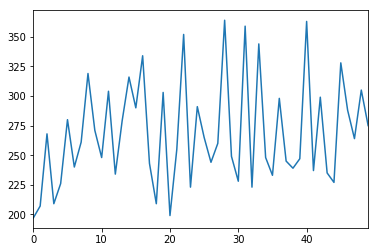

In [10]:
df2['H05B'].plot()

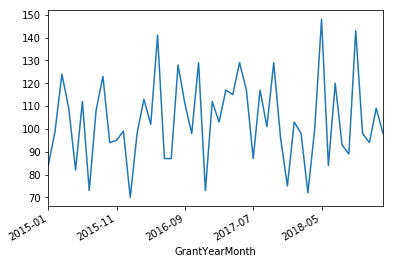

In [9]:
ts1 = df2
ts1 = ts1.set_index('GrantYearMonth')
ts1['A23L'].plot()
plt.gcf().autofmt_xdate()

plt.show()

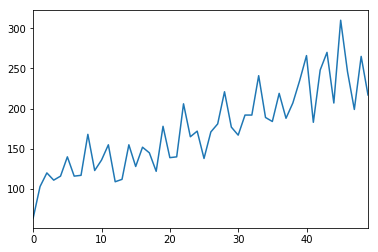

In [23]:
df2['G05D'].plot()

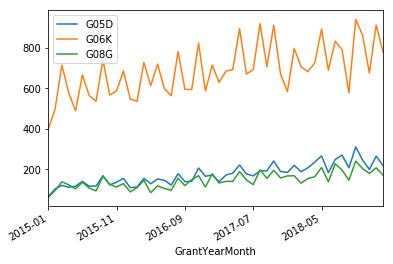

In [14]:
ts1 = df2
ts1 = ts1.set_index('GrantYearMonth')
ts1[test].plot()
plt.gcf().autofmt_xdate()

plt.show()

In [47]:
T = 100
x = np.arange(0,T)
y = np.sin(4*np.pi*x/T)+np.cos(8*np.pi*x/T)
y1 = 100 - x

In [49]:
temp_df = pd.DataFrame(y1, columns=['a'])
get_set_entropy(['a'], temp_df)

[0.17005756325668042]

### The proportion of all the Patent's CPCs to the universe of CPCs

In [10]:
tp = test_df.sum(axis=1)/df2.sum(axis=1)

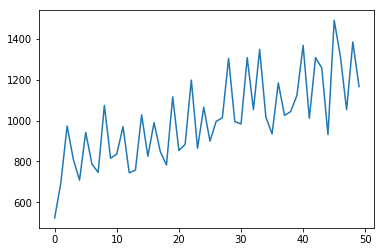

In [13]:
plt.plot(test_df.sum(axis=1))

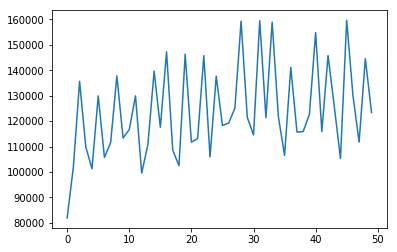

In [14]:
plt.plot(df2.sum(axis=1))

In [11]:
tp_ind = test_df.div(df2.sum(axis=1), axis=0)

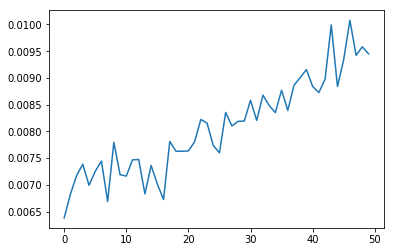

In [12]:
plt.plot(tp)

In [53]:
tp_df = pd.DataFrame(tp, columns=['a'])

In [54]:
tp_ind_df = pd.DataFrame(tp_ind, columns=['a','b','c'])

In [55]:
get_set_entropy(['a'], tp_df)

[0.7044192204880354]

In [18]:
a = get_set_entropy(test, tp_ind)

In [19]:
a

[0.5962612188041119, 0.7630195208271434, 0.8097831937792124]

In [57]:
b = get_set_entropy(test, df2)

In [77]:
np.dot(a,b)/len(a)

0.5045821411635133

In [59]:
np.cross(a,b)

array([-0.01741495,  0.09584428, -0.07748642])

In [65]:
test2 = ['G06Q', 'G07F', 'G06F', 'G07B']

In [66]:
get_set_entropy(test2, df2)

[0.7916071983552897,
 0.6393806514188237,
 0.7404422622181109,
 0.8557553806672604]

In [68]:
tp_ind2 = df2[test2].div(df2.sum(axis=1), axis=0)

In [70]:
get_set_entropy(test2, tp_ind2)

[0.9661711940915613,
 0.8535862471863439,
 0.6859658271637936,
 0.8338623138218684]

In [102]:
c = get_set_entropy(test2, df2)
d = get_set_entropy(test2, tp_ind2)

angle(c,d)

0.14574318780293846

In [98]:
def angle(vector1, vector2):
    import numpy
    numerator = numpy.dot(vector1, vector2)
    denominator = numpy.linalg.norm(vector1) * numpy.linalg.norm(vector2)
    x = numerator / denominator if denominator else 0
    return numpy.arccos(x)

In [95]:
angle(a,b)

0.08204391694117932

In [10]:
test3 = ['A23L', 'H']

In [11]:
get_set_entropy(test3, df2)

[0.9475029799092629, 0.7758516653112965]

In [12]:
tp_ind3 = df2[test3].div(df2.sum(axis=1), axis=0)

In [13]:
get_set_entropy(test3, tp_ind3)

[0.8190978282984953, 0.6735634832885025]

In [96]:
c = get_set_entropy(test3, df2)
d = get_set_entropy(test3, tp_ind3)

angle(c,d)

0.03297928936718432

In [109]:
x = [1]
y = [0.000000001]

angle(x,y)

0.0